In [96]:
import pandas as pd
import numpy as np
import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [97]:
from datasets import load_dataset

dataset = load_dataset("shahxeebhassan/human_vs_ai_sentences")

for k in dataset.keys():
    dataset[k].to_csv(f'../data/{k}_human_vs_ai_sentences.csv', index = False)

Creating CSV from Arrow format: 100%|██████████| 105/105 [00:00<00:00, 206.28ba/s]


In [99]:
df = pd.read_csv("../data/train_human_vs_ai_sentences.csv")
df.head(5)

,text,label
0,Another reason why all students should have to...,0
1,Also the Electoral College consists of 538 ele...,0
2,Many countries have made changes in there town...,0
3,I believe the process of choosing a president ...,0
4,A thick cloud of carbon dioxide and heats to h...,0


In [ ]:
print(f"Human texts: {(df['label'] == 0).sum()}")

print(f"AI texts: {(df['label'] == 1).sum()}")

Human texts: 52500
AI texts: 52500


In [122]:
idx = 103231

print(f"label: {df['label'][idx]}")
print(f"text: {df['text'][idx]}")

label: 1
text: With care and restraint, it could offer supplemental perspective; but left unguided, continual emotional profiling risks doing more harm through its effects on psychological safety, autonomy and the student-teacher relationship.


## Analysis

In [7]:
#Sample
df = df.sample(10000, random_state=0)

In [76]:
nlp = spacy.load("en_core_web_sm")

rows = []

for _, row in df.iterrows():
    doc = nlp(row.text)

    rows.append({
        "vector": doc.vector,
        "symbol_count": len(row.text),
        "token_count": len(doc),
        "token_len": len(row.text)/len(doc),
        "sentence_count": len(list(doc.sents)),
        "unique_tokens_count": len(set([t.text for t in doc if not t.is_punct])),
        "unique_token_ratio": len(set([t.text for t in doc if not t.is_punct])) / len(doc),
        "stop_word_ratio": len([t for t in doc if t.is_stop]) / len(doc),
        "comma_density": row.text.count(',') / max(len(row.text), 1) * 1000,
        "period_density": row.text.count('.') / max(len(row.text), 1) * 1000
    })

f_df = pd.DataFrame(rows)
f_df = pd.concat([df['label'].reset_index(drop=True), f_df.reset_index(drop=True)], axis=1)

label_map = {0: "Human", 1: "AI"}
f_df["label_text"] = f_df["label"].map(label_map)

In [77]:
f_df

,label,vector,symbol_count,token_count,token_len,sentence_count,unique_tokens_count,unique_token_ratio,stop_word_ratio,comma_density,period_density,label_text
0,1,"[-0.37548882, -0.27621207, -0.10975007, -0.134...",71,14,5.071429,1,12,0.857143,0.500000,0.000000,14.084507,AI
1,0,"[-0.2696849, -0.13236189, 0.08262889, -0.01146...",178,36,4.944444,1,23,0.638889,0.416667,16.853933,5.617978,Human
2,1,"[0.009406307, -0.32786164, 0.051851757, -0.101...",183,33,5.545455,1,26,0.787879,0.575758,5.464481,5.464481,AI
3,0,"[0.2291652, 0.4451469, -0.24918771, -1.2330818...",18,3,6.000000,1,2,0.666667,0.000000,0.000000,55.555556,Human
4,1,"[-0.28644896, -0.39041477, 0.40360314, -0.1074...",43,13,3.307692,1,10,0.769231,0.461538,46.511628,0.000000,AI
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,"[0.19264492, -0.2870953, 0.15072444, 0.1264851...",102,23,4.434783,1,18,0.782609,0.478261,9.803922,0.000000,AI
9996,1,"[-0.25524887, -0.4190306, 0.25458327, -0.14346...",69,17,4.058824,1,16,0.941176,0.647059,0.000000,14.492754,AI
9997,0,"[-0.43663687, -0.48110798, 0.5521626, -0.01338...",250,61,4.098361,1,34,0.557377,0.754098,4.000000,4.000000,Human
9998,0,"[-0.30400282, 0.0024729446, -0.1280509, -0.048...",51,12,4.250000,1,9,0.750000,0.416667,39.215686,19.607843,Human


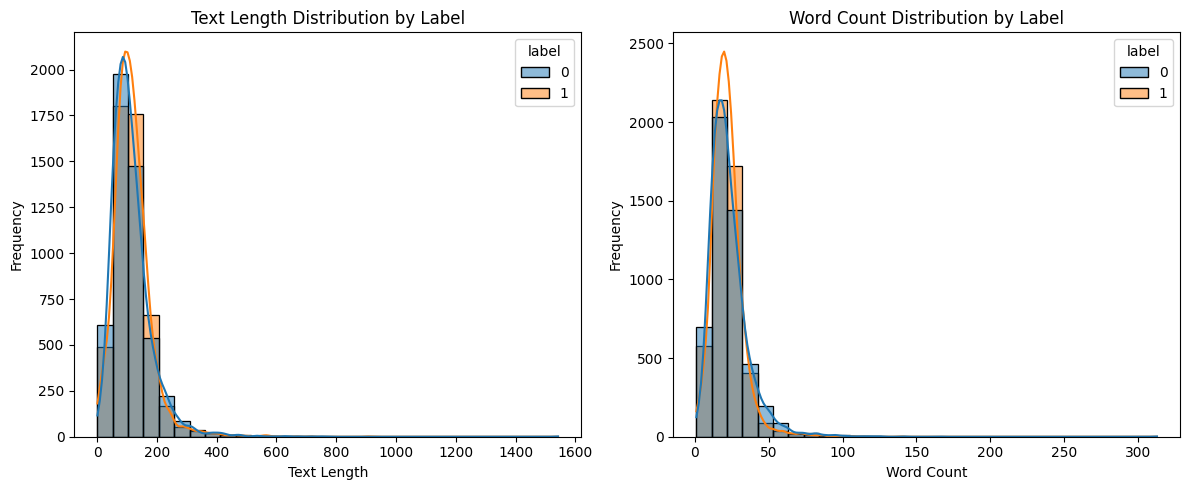

In [109]:


plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=f_df, x='symbol_count', hue='label', bins=30, kde=True)
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=f_df, x='token_count', hue='label', bins=30, kde=True)
plt.title('Word Count Distribution by Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [79]:
f_df.columns

Index(['label', 'vector', 'symbol_count', 'token_count', 'token_len',
       'sentence_count', 'unique_tokens_count', 'unique_token_ratio',
       'stop_word_ratio', 'comma_density', 'period_density', 'label_text'],
      dtype='object')

In [80]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                10000 non-null  int64  
 1   vector               10000 non-null  object 
 2   symbol_count         10000 non-null  int64  
 3   token_count          10000 non-null  int64  
 4   token_len            10000 non-null  float64
 5   sentence_count       10000 non-null  int64  
 6   unique_tokens_count  10000 non-null  int64  
 7   unique_token_ratio   10000 non-null  float64
 8   stop_word_ratio      10000 non-null  float64
 9   comma_density        10000 non-null  float64
 10  period_density       10000 non-null  float64
 11  label_text           10000 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 937.6+ KB


<Axes: xlabel='token_count', ylabel='Count'>

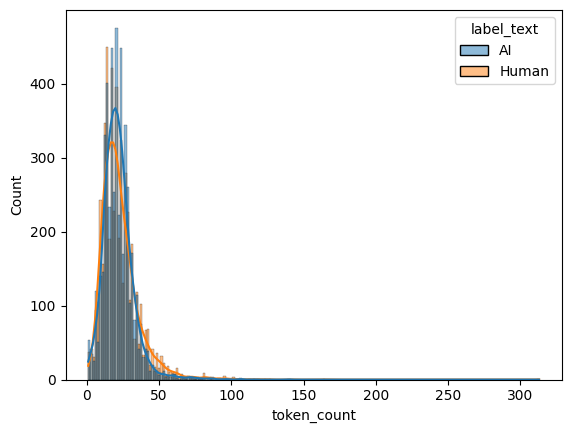

In [89]:
sns.histplot(data=f_df, x='token_count', hue='label_text', kde=True)

<Axes: xlabel='token_count', ylabel='Count'>

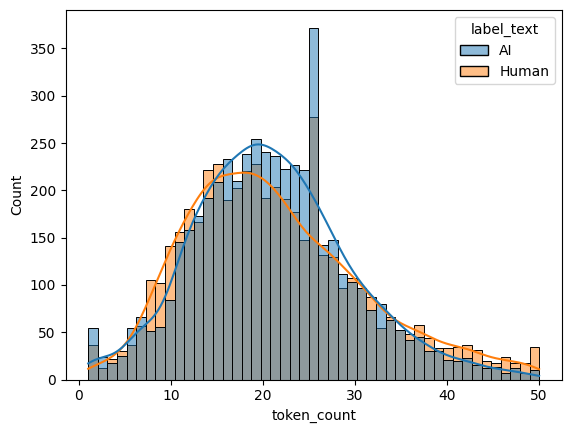

In [84]:
sns.histplot(data=f_df[f_df["token_count"] <= 50].reset_index(drop=True), x='token_count', hue='label_text', kde=True)

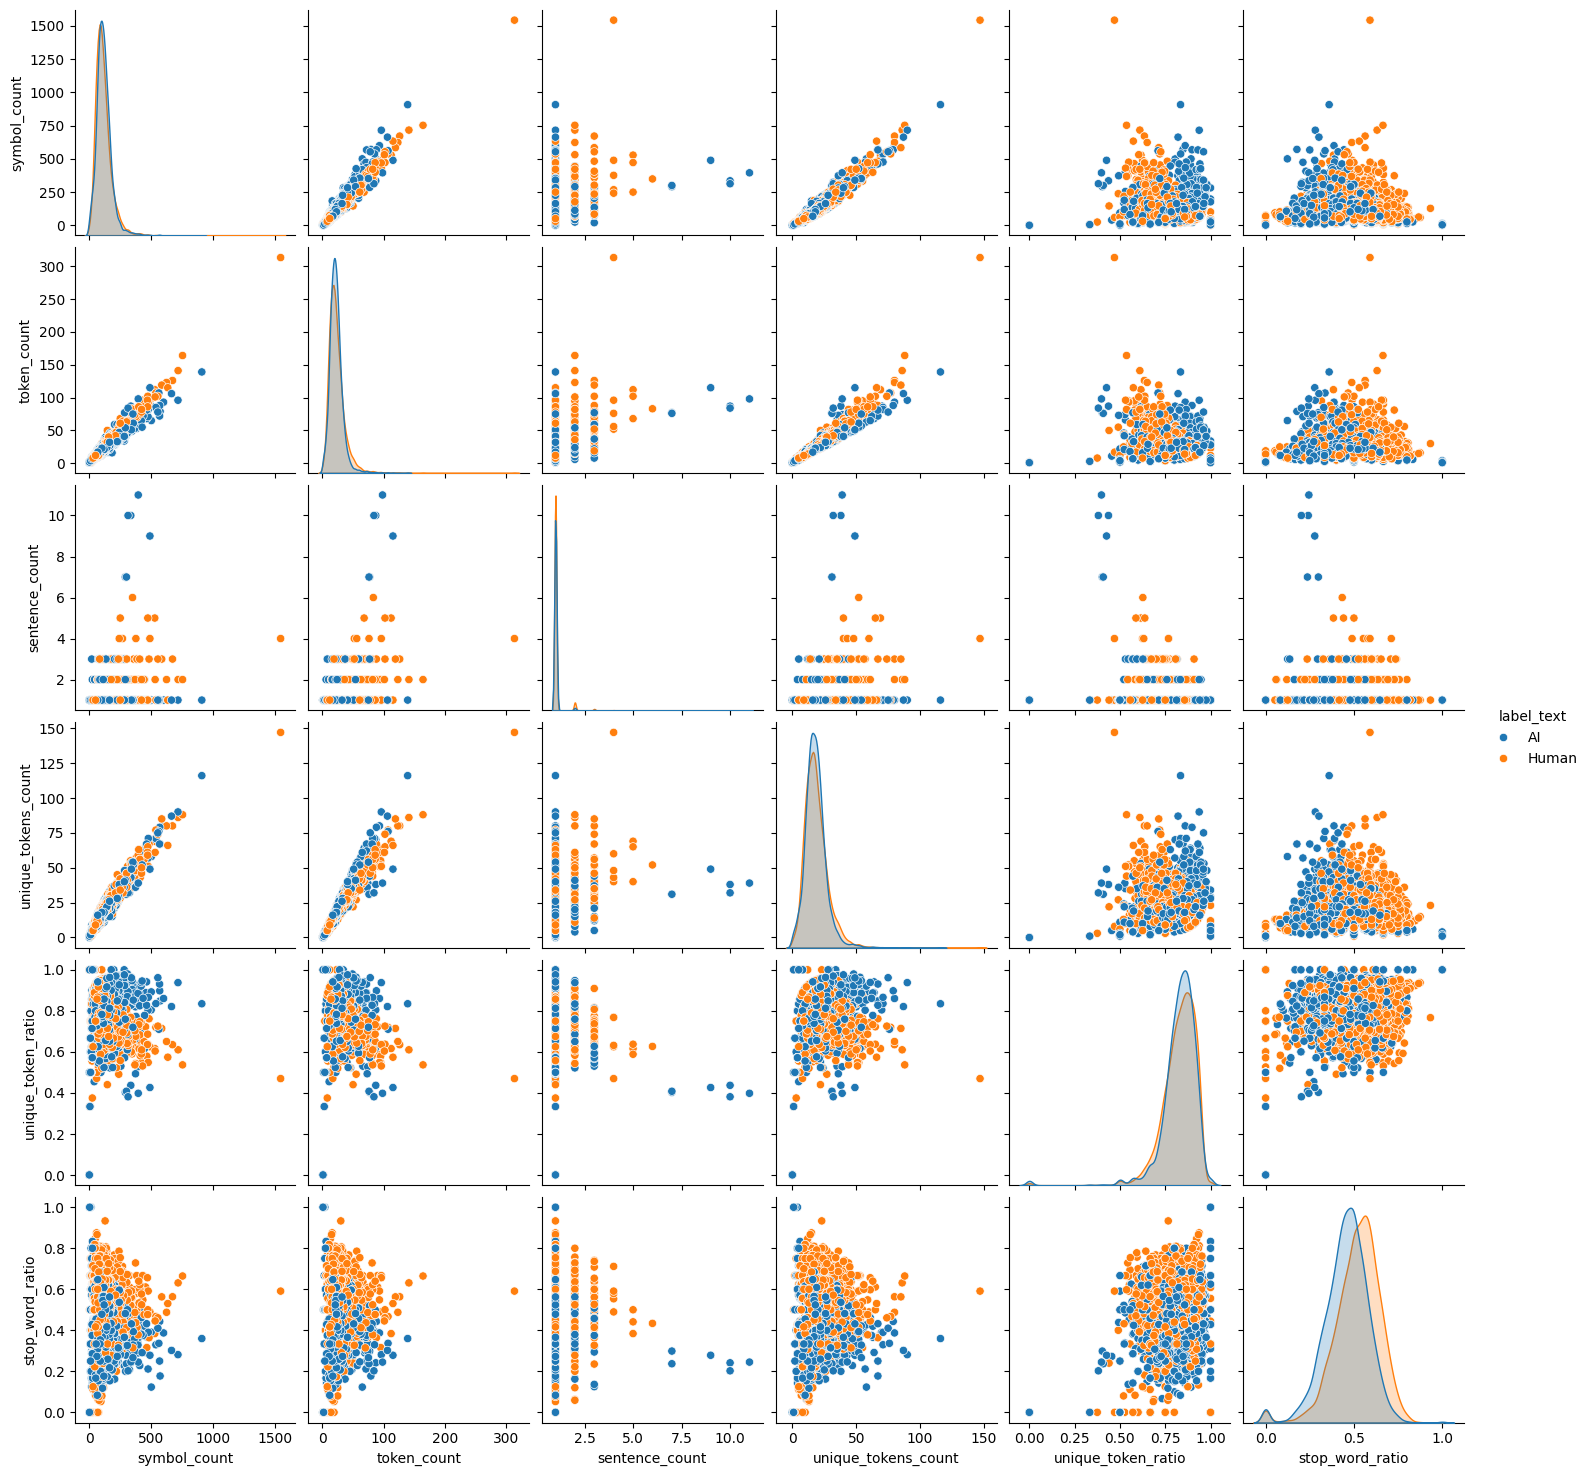

In [83]:
g = sns.pairplot(f_df.drop('vector', axis=1), hue='label_text', vars=['symbol_count', 'token_count', 'sentence_count', 'unique_tokens_count', 
                                                             'unique_token_ratio', 'stop_word_ratio'])

# Classifying

In [93]:
x = np.vstack(f_df['vector'].values)
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = Sequential([
    Dense(96, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=10, validation_split=0.2)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5942 - loss: 0.6794 - val_accuracy: 0.6781 - val_loss: 0.6539
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6888 - loss: 0.6275 - val_accuracy: 0.7019 - val_loss: 0.5925
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7159 - loss: 0.5729 - val_accuracy: 0.7050 - val_loss: 0.5557
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7409 - loss: 0.5348 - val_accuracy: 0.7294 - val_loss: 0.5308
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7486 - loss: 0.5127 - val_accuracy: 0.7325 - val_loss: 0.5241
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7609 - loss: 0.4956 - val_accuracy: 0.7387 - val_loss: 0.5168
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7652 - loss: 0.4851 - val_accuracy: 0.7450 - val_loss: 0.5152
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7759 - loss: 0.4750 - val_accuracy: 0.7456 - val_los

In [94]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.5248
Test Accuracy: 0.7485


In [ ]:
vec_df = pd.DataFrame(f_df['vector'].tolist(), index=f_df.index)
other_features = f_df.drop(columns=['vector', 'label', 'label_text'])

x = pd.concat([vec_df, other_features], axis=1).values
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

model = Sequential([
    Dense(105, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=500, epochs=10, validation_split=0.2)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5244 - loss: 1.2168 - val_accuracy: 0.5788 - val_loss: 0.8240
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5947 - loss: 0.7150 - val_accuracy: 0.5813 - val_loss: 0.6984
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6363 - loss: 0.6474 - val_accuracy: 0.6969 - val_loss: 0.5930
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6997 - loss: 0.5918 - val_accuracy: 0.6888 - val_loss: 0.5855
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7044 - loss: 0.5772 - val_accuracy: 0.7181 - val_loss: 0.5624
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7139 - loss: 0.5681 - val_accuracy: 0.7119 - val_loss: 0.5636
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7228 - loss: 0.5600 - val_accuracy: 0.7156 - val_loss: 0.5514
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7267 - loss: 0.5468 - val_accuracy: 0.7287 - val_

In [91]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7160 - loss: 0.5516
Test Accuracy: 0.7160
